In [1]:
# import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from eemeter.development.data import HourlyData
from itertools import combinations
# import time

# from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
# from eemeter.common.metrics import BaselineTestingMetrics as Metrics
from scipy.interpolate import RBFInterpolator

# import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
#load subsamples from the main MCE dataset
dataset = 'mce'
subsample = 2
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_meta_2.pkl
Done in 0.010 s
Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_hourly_meter_2.pkl


Done in 5.839 s


### Hourly model setting

In [13]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    # SUPPLEMENTAL_DATA=None,
    SUPPLEMENTAL_DATA= {'TS_SUPPLEMENTAL': None,
                        'CATEGORICAL_SUPPLEMENTAL': {'PV_INSTALLATION_DATE': "2019-05-14"},},
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

### Get a single meter data and pass it through hourlydata class

In [14]:
# get one meter
i=14
meter_id = ids[i]
meter = subsample_df.loc[meter_id].copy()
# PV_interventation = "2019-11-09"
PV_interventation = "2019-05-14"

# #change PV_interventation to datetime
# PV_interventation = pd.to_datetime(PV_interventation)
# meter['solar_supp'] = 0
# meter.loc[meter['date'] >= PV_interventation.date(), 'solar_supp'] = 1

# select baseline period
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

meta_meter = meta.loc[meter_id]

# get unique pair of station_latitude and station_longitude
unique_pairs = meta_meter[['station_latitude', 'station_longitude']].drop_duplicates()

# print unique pairs
METADATA = {
    'station_latitude': unique_pairs['station_latitude'].values[0],
    'station_longitude': unique_pairs['station_longitude'].values[0],
}

#TODO: keep it simple and let the input force the output
OUTPUT_FEATURES=['temperature', 'observed', 'model']

if 'ghi' in settings.TRAIN_FEATURES:
    CONSIDER_SOLAR = True
    OUTPUT_FEATURES.append('ghi')
    OUTPUT_FEATURES.append('clearsky_ghi')
else:
    CONSIDER_SOLAR = False
kwargs = {
    'solar': CONSIDER_SOLAR,
    'metadata': METADATA,
    'outputs': OUTPUT_FEATURES,
}

if meter_baseline.empty:
    print('empty baseline')
    pass
    
data_baseline = HourlyData(meter_baseline, **kwargs)
print(i)


14


## Test Supplemental data

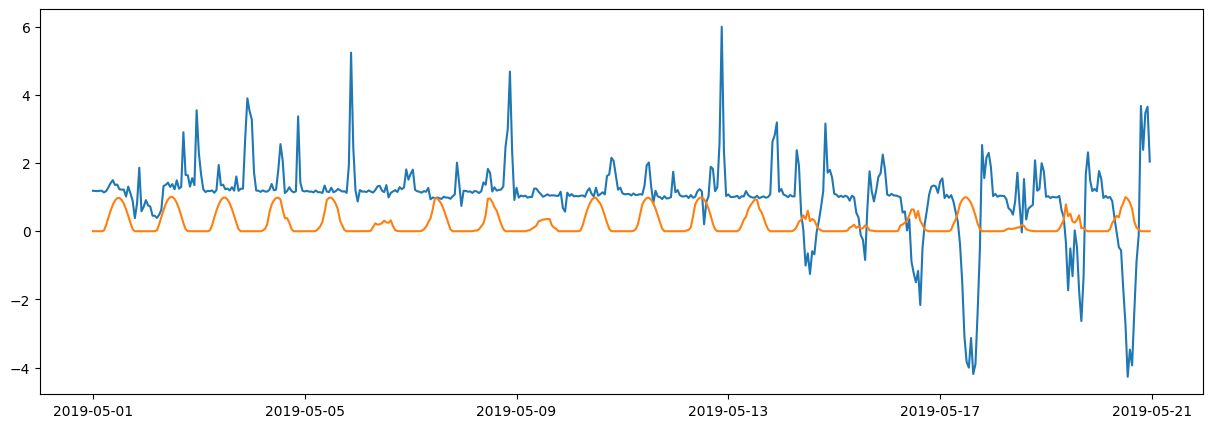

In [24]:
#This is for id = 14 for subsample 2 and has_net = True from MCE dataset
st = 24*60
w = 24*20
en = st + w
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(data_baseline.df['observed'][st:en])
plt.plot(data_baseline.df['ghi'][st:en])
plt.show()

# consider pv installation as time series data

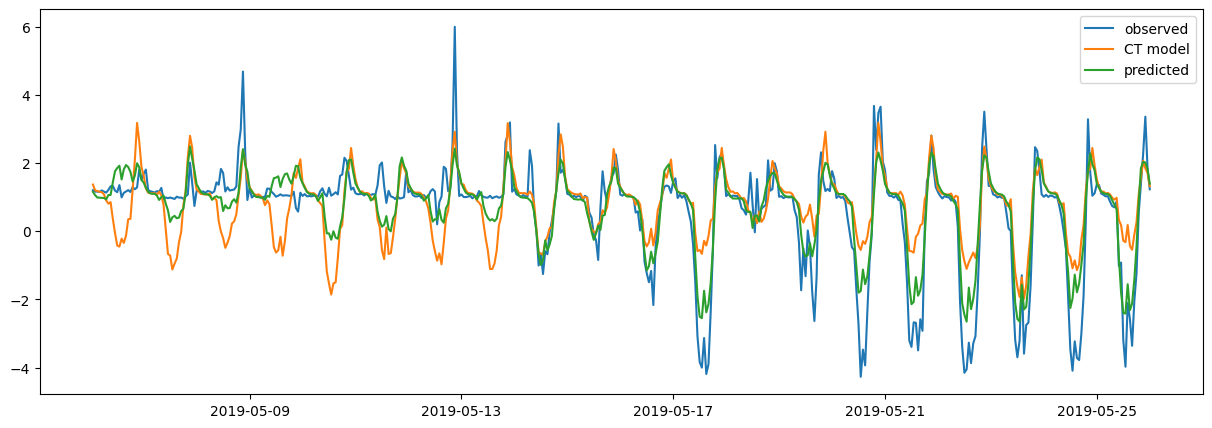

0.8132008570204327


In [34]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    # SUPPLEMENTAL_DATA=None,
    SUPPLEMENTAL_DATA= {'TS_SUPPLEMENTAL': {'HAS_PV'},
                        'CATEGORICAL_SUPPLEMENTAL': {},},
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

PV_interventation = "2019-05-14"
PV_interventation = pd.to_datetime(PV_interventation)
data_baseline.df['HAS_PV'] = 0
data_baseline.df['date'] = data_baseline.df.index.date
data_baseline.df.loc[data_baseline.df['date'] >= PV_interventation.date(), 'HAS_PV'] = 1

model = em.HourlyModel(settings=settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


st = 24*65
w = 24*20
en = st + w
plt.plot(pred_baseline['observed'][st:en], label='observed')
# plt.plot(pred_baseline['ghi'][st:en])
plt.plot(pred_baseline['model'][st:en], label='CT model')
plt.plot(pred_baseline['predicted'][st:en], label='predicted')
plt.legend()
plt.show()

print(model.baseline_metrics.pnrmse)

# consider pv installation as categorical data

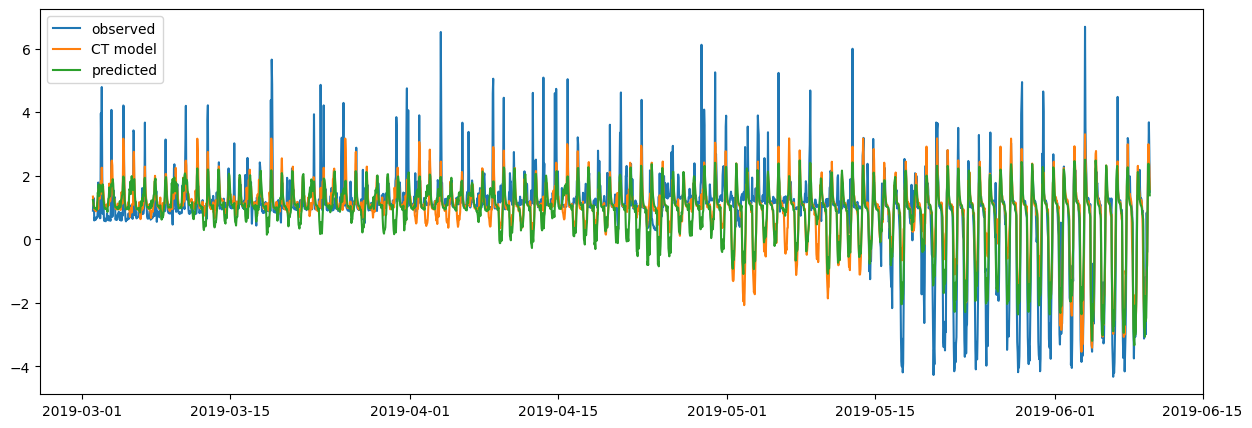

0.8536073130781259


In [38]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
PV_interventation = "2019-05-14"
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    # SUPPLEMENTAL_DATA=None,
    SUPPLEMENTAL_DATA= {'TS_SUPPLEMENTAL': None,
                        'CATEGORICAL_SUPPLEMENTAL': {'PV_INSTALLATION_DATE': PV_interventation},},
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

model = em.HourlyModel(settings=settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


st = 24*0
w = 24*100
en = st + w
plt.plot(pred_baseline['observed'][st:en], label='observed')
# plt.plot(pred_baseline['ghi'][st:en])
plt.plot(pred_baseline['model'][st:en], label='CT model')
plt.plot(pred_baseline['predicted'][st:en], label='predicted')
plt.legend()
plt.show()
print(model.baseline_metrics.pnrmse)

# no supplemental data

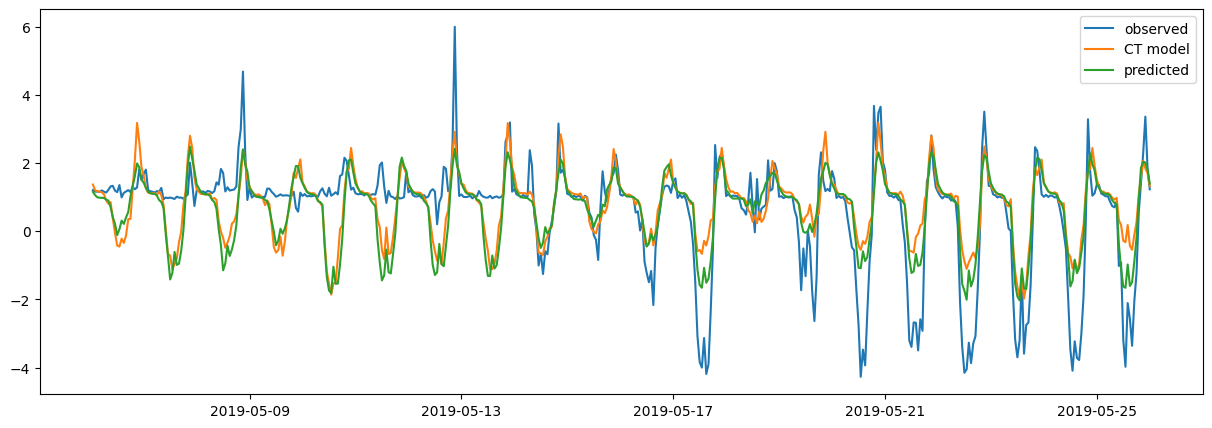

0.9202266052951105


In [36]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
PV_interventation = "2019-05-14"
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    SUPPLEMENTAL_DATA=None,
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

model = em.HourlyModel(settings=settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


st = 24*65
w = 24*20
en = st + w
plt.plot(pred_baseline['observed'][st:en], label='observed')
# plt.plot(pred_baseline['ghi'][st:en])
plt.plot(pred_baseline['model'][st:en], label='CT model')
plt.plot(pred_baseline['predicted'][st:en], label='predicted')
plt.legend()
plt.show()
print(model.baseline_metrics.pnrmse)

### Loop through a subsample to see which ids have missing data problem

In [13]:
#TODO: keep it simple and let the input force the output
OUTPUT_FEATURES=['temperature', 'observed', 'model']
if 'solar_supp' in settings.TRAIN_FEATURES:
    OUTPUT_FEATURES.append('solar_supp')
if 'ghi' in settings.TRAIN_FEATURES:
    CONSIDER_SOLAR = True
    OUTPUT_FEATURES.append('ghi')
    OUTPUT_FEATURES.append('clearsky_ghi')
else:
    CONSIDER_SOLAR = False


arglist = []
for i, meter_id in enumerate(ids):
    meta_meter = meta.loc[meter_id]
    # get unique pair of station_latitude and station_longitude
    unique_pairs = meta_meter[['station_latitude', 'station_longitude']].drop_duplicates()
    try:
        try:
            METADATA = {
            'station_latitude': unique_pairs['station_latitude'][0],
            'station_longitude': unique_pairs['station_longitude'][0],
            }
        except:
            METADATA = {
            'station_latitude': unique_pairs['station_latitude'],
            'station_longitude': unique_pairs['station_longitude'],
            }
    except:
        try:
            METADATA = {
                'station_latitude': unique_pairs['station_latitude'].values[0],
                'station_longitude': unique_pairs['station_longitude'].values[0],
                }
        except:
            pass
        
    kwargs = {
    'solar': CONSIDER_SOLAR,
    'metadata': METADATA,
    'outputs': OUTPUT_FEATURES,
    }
    arglist.append((i, meter_id, kwargs))


def check_df_decorator(arglist):
    i, meter_id, kwargs = arglist
    status = 'None'

    details = [i, meter_id, status]

    try:
        meter = subsample_df.loc[meter_id].copy()
        meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()
        # get unique pair of station_latitude and station_longitude

        if meter_baseline.empty:
            print(f"Skipping {i},   {meter_id} due to empty baseline data")
            details[-1] = 'empty_baseline'
            return details
        data_baseline = HourlyData(meter_baseline, **kwargs)

        if data_baseline.too_many_missing_data:
            print(f" {i},   {meter_id} has {data_baseline.missing_values_amount} missing data")
            details[-1] = 'too_many_missing_data'
            
        if data_baseline.df[data_baseline.to_be_interpolated_columns].isnull().values.any():
            print(f"Skipping {i},   {meter_id} due to missing data, because of interpolaiton failed")
            details[-1] = 'interpolation_failed'
        
        return details
    except:
        print(f"Skipping {i},   {meter_id} due to unknown error")
        details[-1] = 'unknown_error'
        return details

# for i, meter_id, kwargs in arglist:
#     status = check_df_decorator((i, meter_id, kwargs))
#     if status:
#         print(f"Skipping {i},   {meter_id} due to {status}")
#         continue
import multiprocessing as mp
with mp.Pool(mp.cpu_count()-1) as pool:
    results = pool.map(check_df_decorator, arglist)

In [14]:
#value counts of results
results = pd.DataFrame(results, columns=['i', 'meter_id', 'status'])
results['status'].value_counts()

status
None    1000
Name: count, dtype: int64

#### Reasons why we don't use these interpolations

In [ ]:
from scipy.interpolate import RBFInterpolator, griddata, LinearNDInterpolator, NearestNDInterpolator, CloughTocher2DInterpolator

"""griddata: need an actual limit for the input such as temp (like a grid) which we don't want to have
   LinearNDInterpolator" if the data is out of bound based on the train data, it gives us nan :( which is crazy that it doesn't even extrapolate
   NearestNDInterpolator: values are descrete and way off sometimes (we have the mean value of couple of classes)
   CloughTocher2DInterpolator: same as LinearNDInterpolator


   Some crazy interpolation is already happening in the MCE temperature (last week and the day before temperatures were exactly the same (reason we we getting singularity in interpolation))
"""


In [17]:
model = em.HourlyModel(settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)   


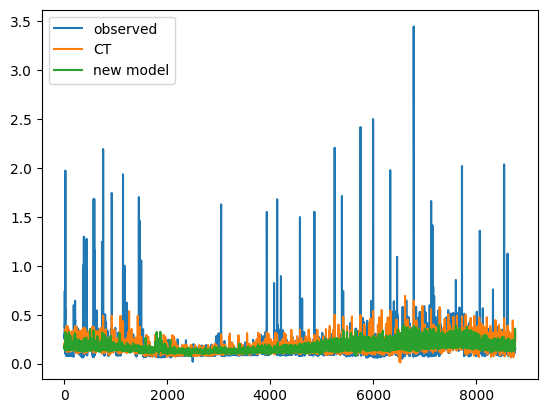

In [18]:
s = 0
w = -1
e = s + w
plt.plot(pred_baseline['observed'].iloc[s:e].values, label='observed')
plt.plot(pred_baseline['model'].iloc[s:e].values, label='CT')
plt.plot(pred_baseline['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [19]:
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()
data_reporting = HourlyData(meter_reporting, **kwargs)
reporting_pred = model.predict(data_reporting)
reporting_pred

,temperature,observed,model,ghi,clearsky_ghi,interpolated_temperature,interpolated_observed,interpolated_ghi,predicted
datetime,,,,,,,,,
2020-03-01 00:00:00,44.58050,0.108200,0.193602,0.0,0.0,False,False,False,0.181502
2020-03-01 01:00:00,43.78850,0.091700,0.166764,0.0,0.0,False,False,False,0.168847
2020-03-01 02:00:00,41.82950,0.116600,0.166356,0.0,0.0,False,False,False,0.177548
2020-03-01 03:00:00,42.79325,0.109600,0.151631,0.0,0.0,False,False,False,0.167446
2020-03-01 04:00:00,43.42175,0.110200,0.149279,0.0,0.0,False,False,False,0.155514
...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,71.21675,0.167300,0.144742,0.0,0.0,False,False,False,0.165976
2021-03-31 20:00:00,60.91475,0.152500,0.201103,0.0,0.0,False,False,False,0.142898
2021-03-31 21:00:00,55.91975,0.145500,0.218641,0.0,0.0,False,False,False,0.170934


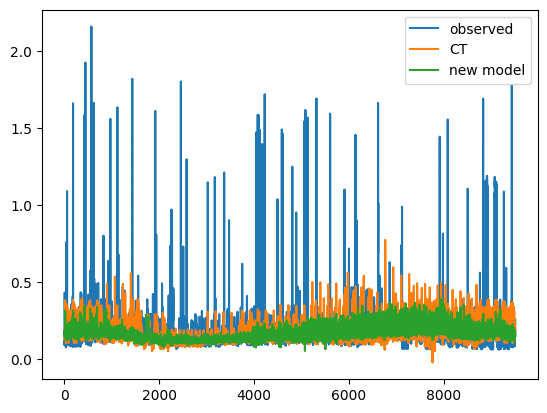

In [20]:
s = 0
w = -1
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [21]:
# pred['temperature'].quantile(0.95)
# find days with temperature above 95th percentile
hot_hours = reporting_pred[reporting_pred['temperature'] > reporting_pred['temperature'].quantile(0.995)]
unique_days = np.unique(hot_hours.index.date)
print(unique_days.shape)

reporting_pred['date'] = reporting_pred.index.date
 # get days that are in unique_days
hot_days = reporting_pred[reporting_pred['date'].isin(unique_days)]
hot_days

(12,)


,temperature,observed,model,ghi,clearsky_ghi,interpolated_temperature,interpolated_observed,interpolated_ghi,predicted,date
datetime,,,,,,,,,,
2020-08-14 00:00:00,68.178500,0.1766,0.170787,0.0,0.0,False,False,False,0.120036,2020-08-14
2020-08-14 01:00:00,66.391250,0.1786,0.167257,0.0,0.0,False,False,False,0.124341,2020-08-14
2020-08-14 02:00:00,66.028250,0.1704,0.155768,0.0,0.0,False,False,False,0.121216,2020-08-14
2020-08-14 03:00:00,67.187750,0.1607,0.148933,0.0,0.0,False,False,False,0.104234,2020-08-14
2020-08-14 04:00:00,68.621750,0.1709,0.139502,0.0,0.0,False,False,False,0.091209,2020-08-14
...,...,...,...,...,...,...,...,...,...,...
2020-10-16 19:00:00,75.473750,0.1624,0.201252,0.0,0.0,False,False,False,0.240215,2020-10-16
2020-10-16 20:00:00,70.707432,0.1538,0.161032,0.0,0.0,False,False,False,0.241782,2020-10-16
2020-10-16 21:00:00,68.279000,0.1492,0.175606,0.0,0.0,False,False,False,0.200003,2020-10-16


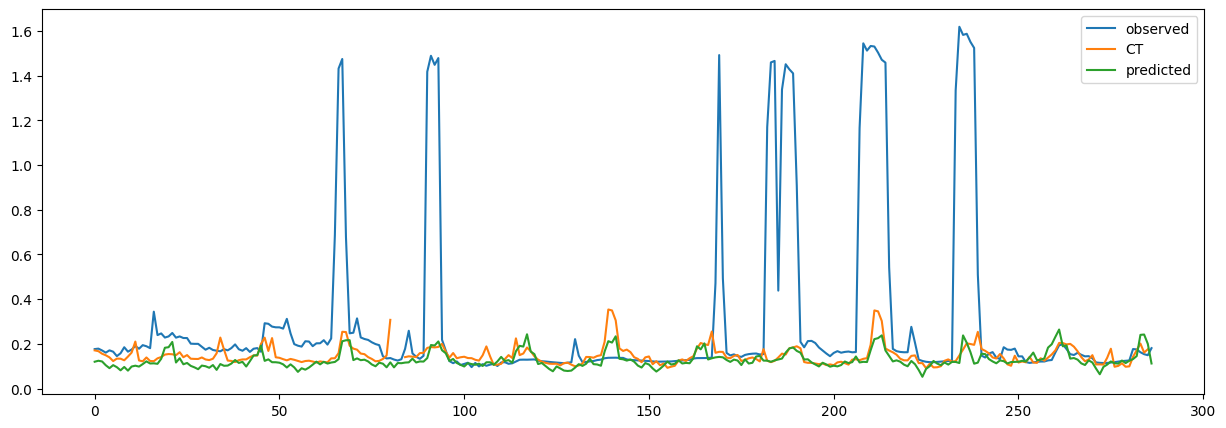

In [22]:
plt.rcParams['figure.figsize'] = [15, 5]
s = 24*0
w = -1
e = s + w
plt.plot(hot_days['observed'].iloc[s:e].values, label='observed')
plt.plot(hot_days['model'].iloc[s:e].values, label='CT')
plt.plot(hot_days['predicted'].iloc[s:e].values, label='predicted')
plt.legend()

# plt.plot(-hot_days['ghi'].iloc[s:e].values*7, label='ghi')

plt.show()

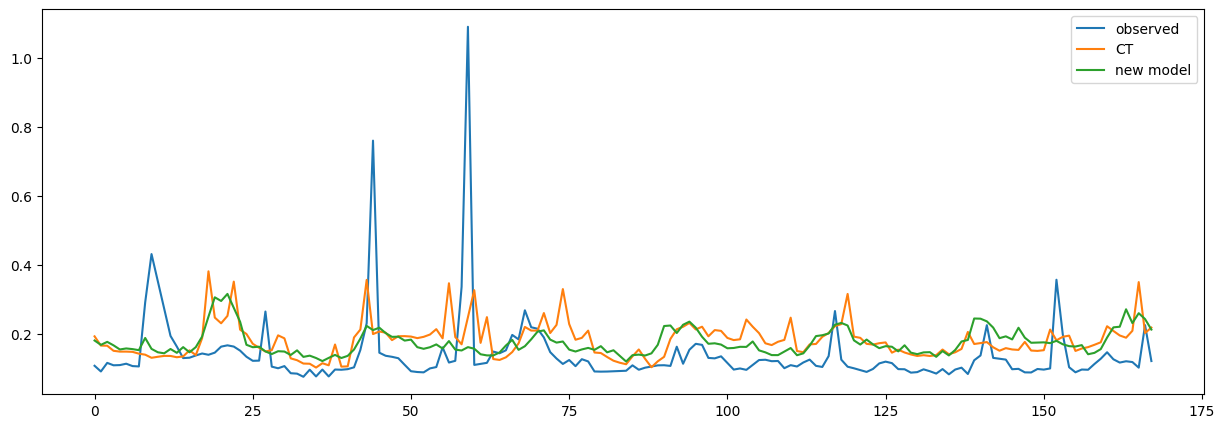

In [23]:
s = 24*0
w = 24*7
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [24]:
def PNRMSE(y_true, y_pred, iqr):
    return np.sqrt(np.mean((y_true - y_pred)**2))/iqr

def CVRMSE(y_true, y_pred, mn):
    return np.sqrt(np.mean((y_true - y_pred)**2))/mn

def MBE(y_true, y_pred):
    return np.mean(y_true - y_pred)



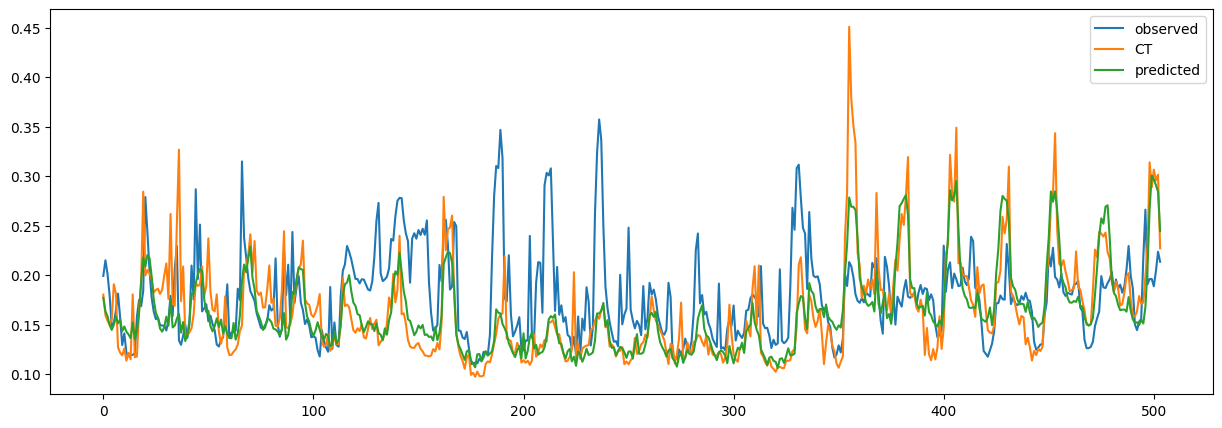

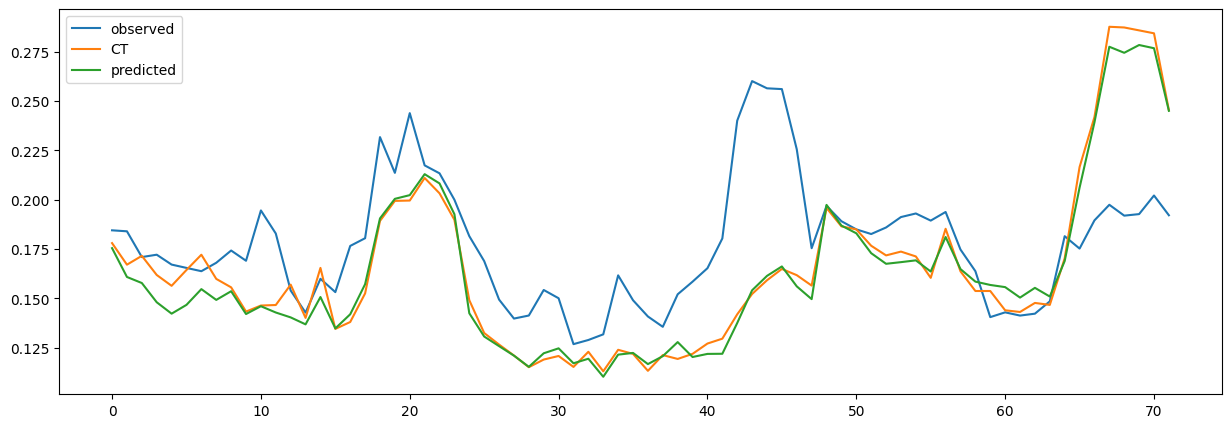

In [25]:
# plot the season/hour_of_week plots
# get the season and hour_of_week
seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
reporting_pred['season'] = reporting_pred.index.month
reporting_pred['season'] = reporting_pred['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
reporting_pred['season'] = reporting_pred['season'].astype('category')

reporting_pred['hour_of_week'] = reporting_pred.index.dayofweek*24 + reporting_pred.index.hour
reporting_pred['hour_of_week'] = reporting_pred['hour_of_week'].astype('category')

reporting_pred['hour'] = reporting_pred.index.hour
reporting_pred['hour'] = reporting_pred['hour'].astype('category')


# get the season/hour_of_week plots
plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()


plt.plot(reporting_pred.groupby(['season', 'hour'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()

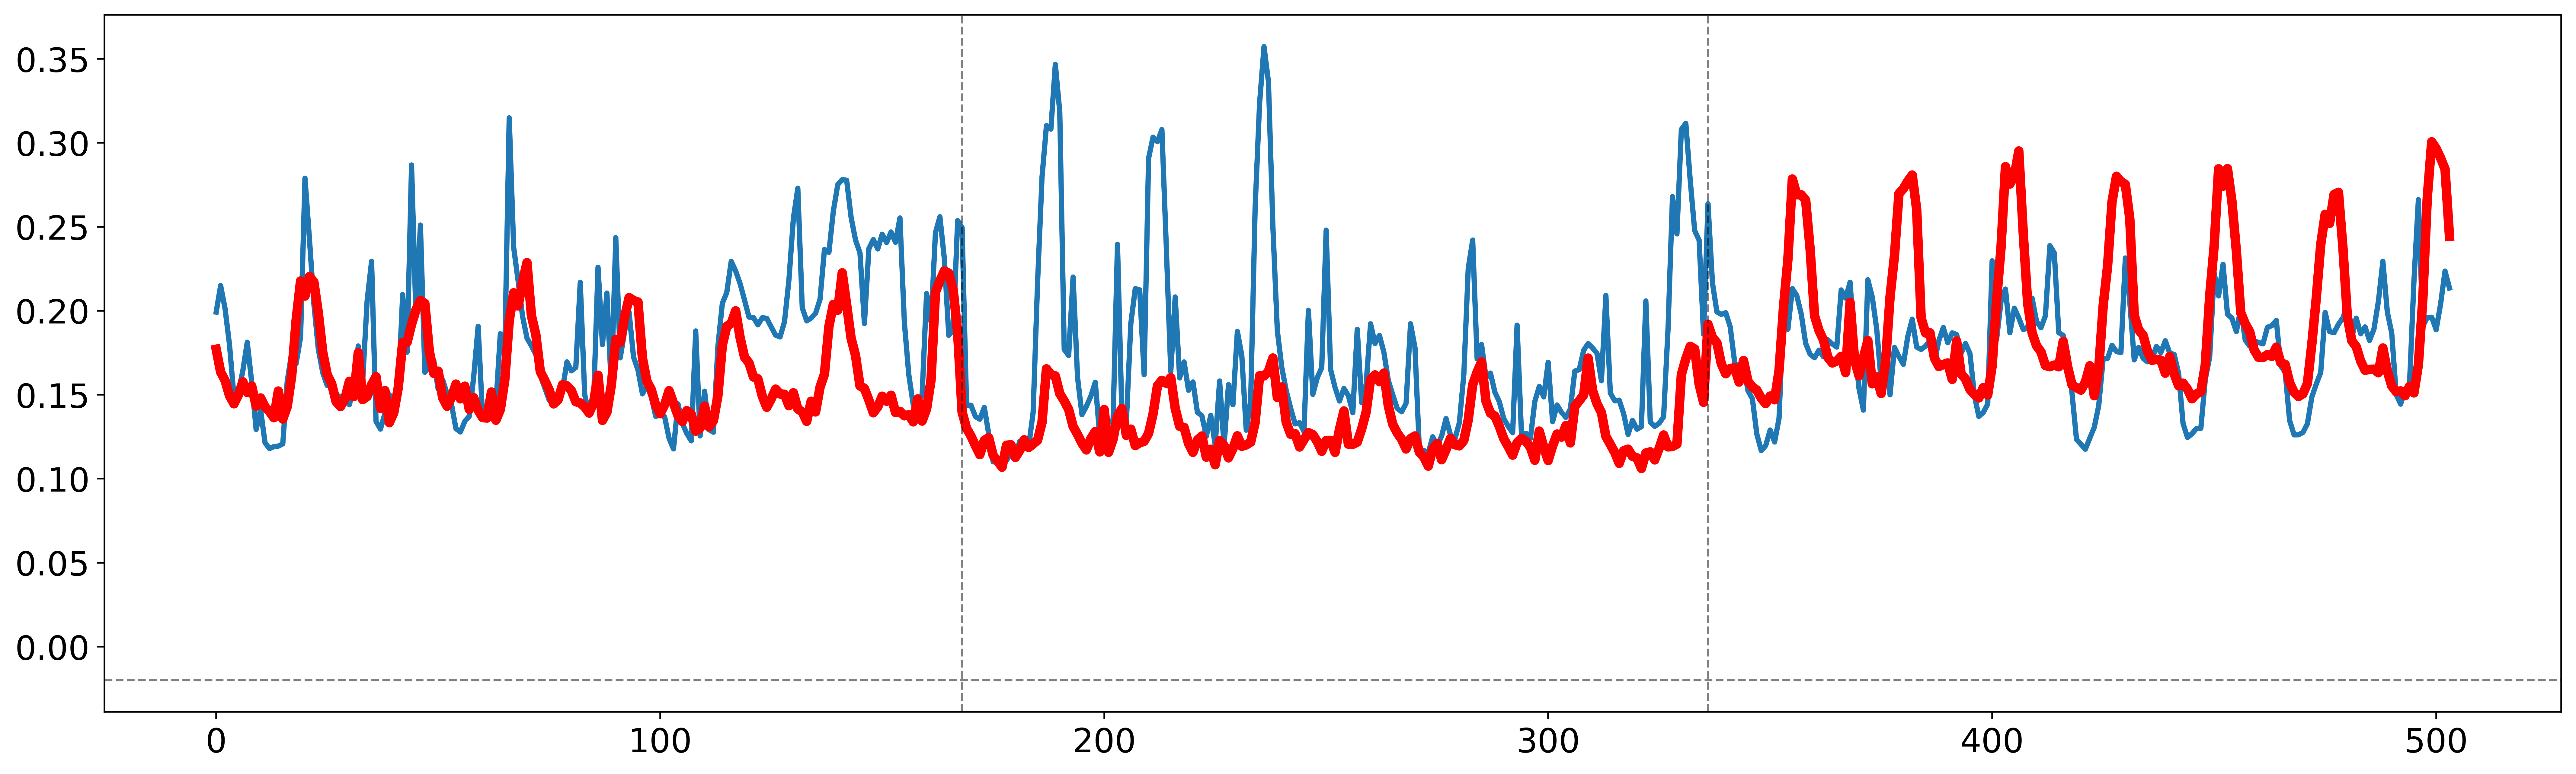

{'PNRMSE': 1.682951806757122,
 'PNRMSE_predicted': 1.6305805316118935,
 'CVRMSE': 1.0048300439395113,
 'CVRMSE_predicted': 0.9735610376054856,
 'MBE': 0.013823826569807759,
 'MBE_predicted': 0.016281104855428677}

In [28]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()

seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
dft['season'] = dft.index.month
dft['season'] = dft['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
dft['season'] = dft['season'].astype('category')

dft['hour_of_week'] = dft.index.dayofweek*24 + dft.index.hour
dft['hour_of_week'] = dft['hour_of_week'].astype('category')

dft['hour'] = dft.index.hour
dft['hour'] = dft['hour'].astype('category')

# plot two weeks of data for oeem , new_model and observed
start = 24*0
pltwindow = 24*7
end = start + pltwindow

plt.rcParams["figure.figsize"] = (21,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 500
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
# plt.plot(dft['observed'][start:end].values, label='observed', linewidth=2.5)

plt.plot(dft.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed', linewidth=2.5)
# plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT',color='red',  linewidth=2.5)
plt.plot(dft.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted', color='red', linewidth=4.5)

# plt.plot(-dft['ghi'][start:end].values*10, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'][start:end].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['new_model'][start:end].values, label='new_model', color='mediumseagreen',linestyle='--', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
plt.axvline(168, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.xticks(fontsize=16)
#change s tick to time
# plt.xticks(dft['start_local'].index[start:end].values, dft['start_local'].index[start:end].values, rotation=45)
plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(-0.02, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.7, 2)
# plt.legend()
plt.show()


iqr = np.percentile(pred_baseline['observed'], 75) - np.percentile(pred_baseline['observed'], 25)
mn = np.mean(pred_baseline['observed'])

# get metrics both for model and predicted based on observed
metrics = {}
metrics['PNRMSE'] = PNRMSE(dft['observed'], dft['model'], iqr)
metrics['PNRMSE_predicted'] = PNRMSE(dft['observed'], dft['predicted'], iqr)
metrics['CVRMSE'] = CVRMSE(dft['observed'], dft['model'], mn)
metrics['CVRMSE_predicted'] = CVRMSE(dft['observed'], dft['predicted'], mn)
metrics['MBE'] = MBE(dft['observed'], dft['model'])
metrics['MBE_predicted'] = MBE(dft['observed'], dft['predicted'])

metrics

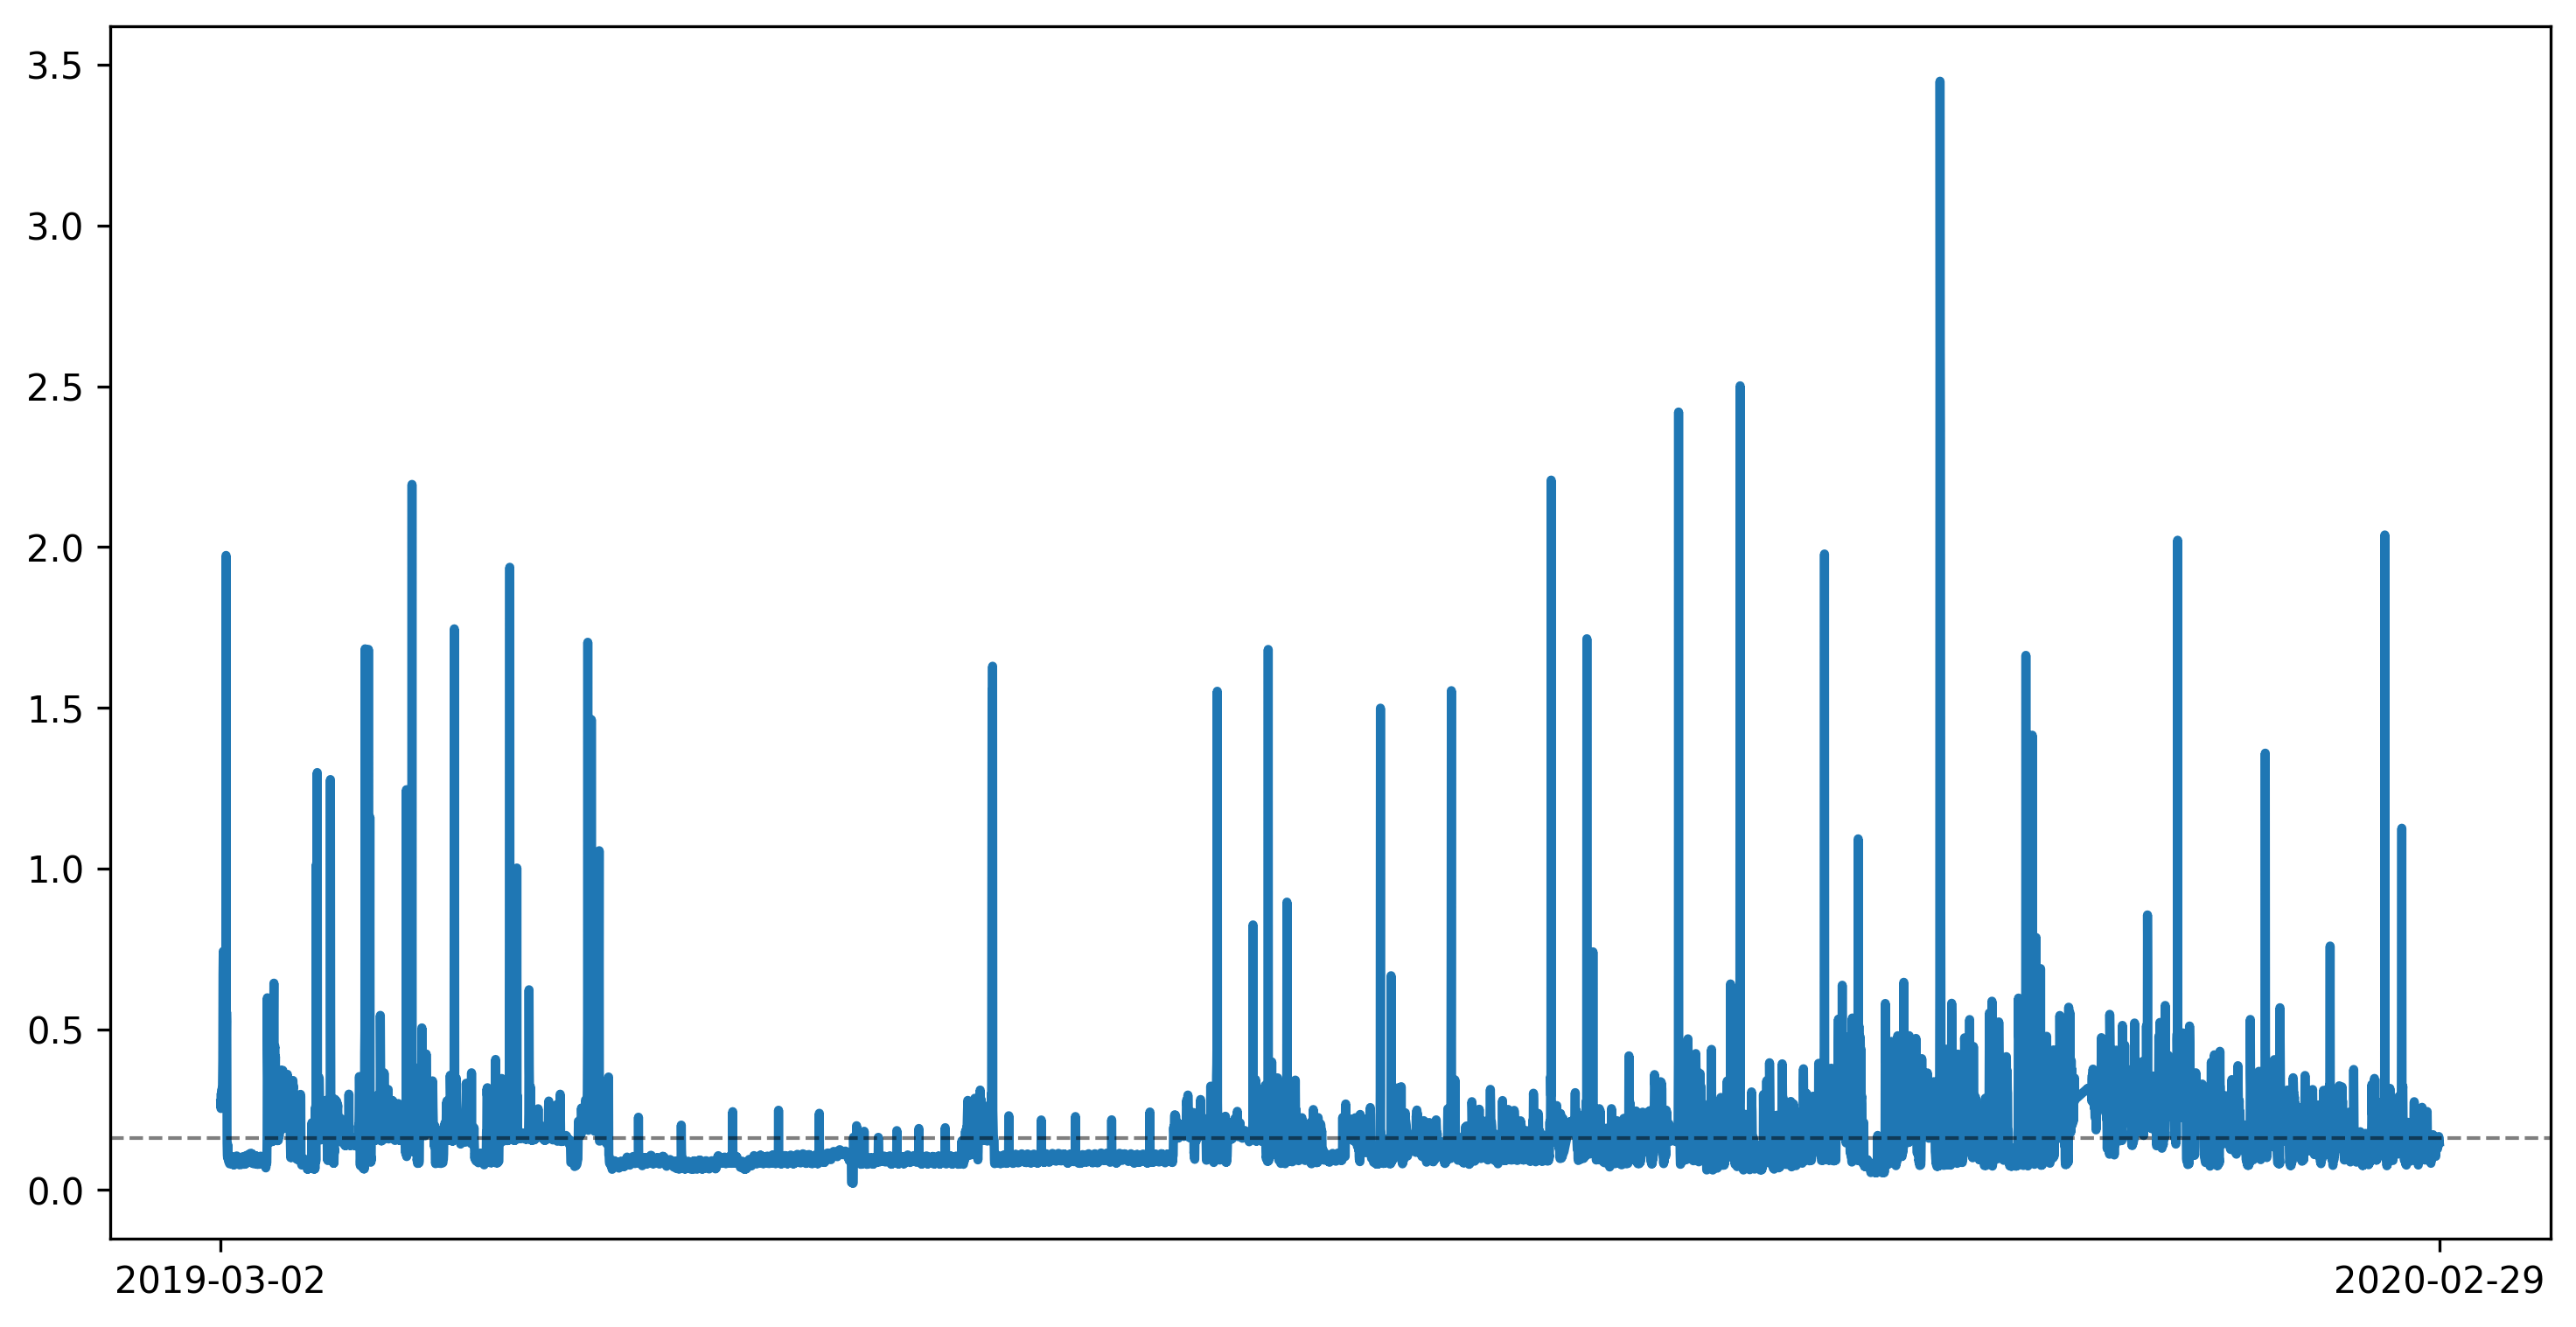

In [27]:
# dft = reporting_pred.copy()
dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
# plt.xticks([0, 11, 23, 35, 47], [1, 12, 24, 36, 48])

# add the first and the last date to the xticks
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])

# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
# dft = pred_baseline.copy()
# dft['observed'].describe()
# idx = dft['observed'].argmin() -24*2
# print(idx)

# selected_date = dft.index[idx].date()
# # get the data for the selected date
# selected_data = dft[dft.index.date == selected_date]


In [ ]:
start = 24*0
pltwindow = -1
end = start + pltwindow
dft = selected_data.copy()
dft = repo
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)

#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

plt.show()

In [ ]:
634.4/208

In [ ]:
meta_meter

In [ ]:
reporting_pred

In [ ]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(0, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
reporting_pred.describe()

In [ ]:
# select reporting period after the intervention
selected = reporting_pred.loc[reporting_pred.index >= PV_interventation]
selected.describe()